Решение путем внутренней агрегации семантики

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_path = "/content/gdrive/My Drive/Models/"

In [ ]:
pip install transformers

     |████████████████████████████████| 1.4MB 9.9MB/s 
     |████████████████████████████████| 2.9MB 45.0MB/s 
     |████████████████████████████████| 890kB 78.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8eae7d6fd4df7866f0f6342abff41e183ca1b2a44b80a341e0775e0474b04763
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 32.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 27.1MB/s]


In [ ]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape

(15746, 11)

In [ ]:
df.info

<bound method DataFrame.info of                 userName  ...              appId
0          Andrew Thomas  ...          com.anydo
1           Craig Haines  ...          com.anydo
2          steven adkins  ...          com.anydo
3       Lars Panzerbjørn  ...          com.anydo
4          Scott Prewitt  ...          com.anydo
...                  ...  ...                ...
15741          Tammy Kay  ...  com.appxy.planner
15742          Ysm Johan  ...  com.appxy.planner
15743      casey dearden  ...  com.appxy.planner
15744     Jerry G Tamate  ...  com.appxy.planner
15745  Ahmed elsalamouni  ...  com.appxy.planner

[15746 rows x 11 columns]>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 8, 6

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'score')

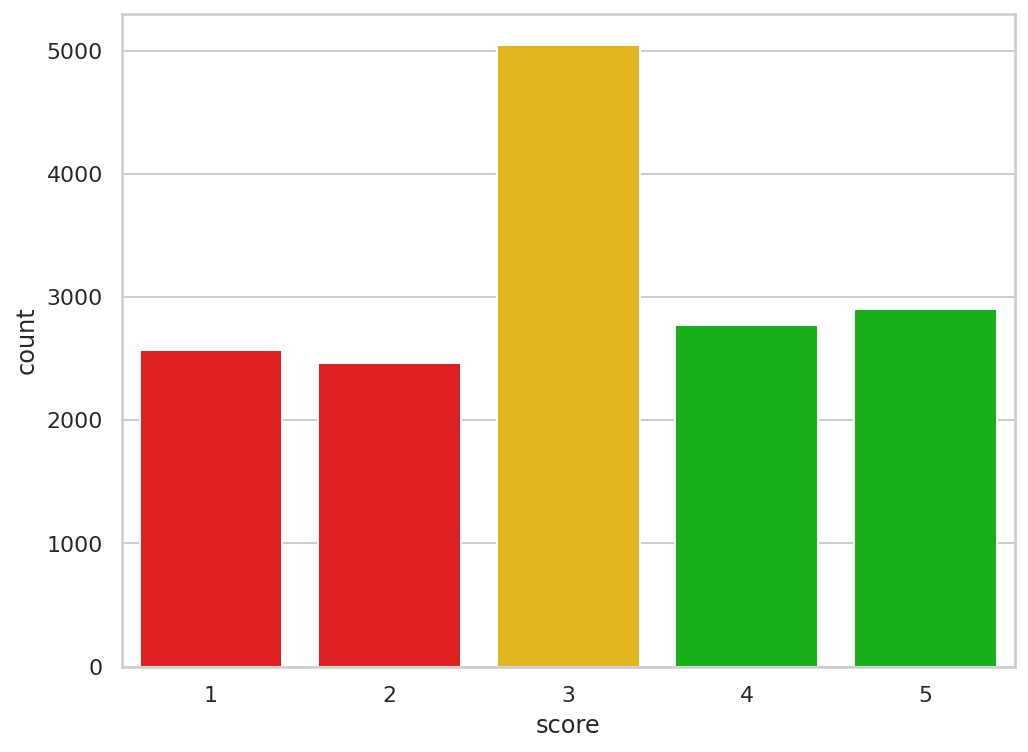

In [ ]:
sns.set(style='whitegrid')
sns.set_palette(sns.color_palette(["#ff0000", "#ff0000", "#ffc800", "#00c800", "#00c800"]))
sns.countplot(df.score)
plt.xlabel('score')

In [ ]:
counts = [0, 0, 0, 0, 0]
for i in range(len(df['score'])):
  counts[df['score'][i] - 1] += 1

In [ ]:
counts

[2566, 2462, 5042, 2776, 2900]

In [ ]:
def scr2snt(scr):
  scr = int(scr)
  if scr <= 2:
    return 0
  elif scr == 3:
    return 1
  else:
    return 2

In [ ]:
df['sentiment'] = df.score.apply(scr2snt)

In [ ]:
tags = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'sentiment')

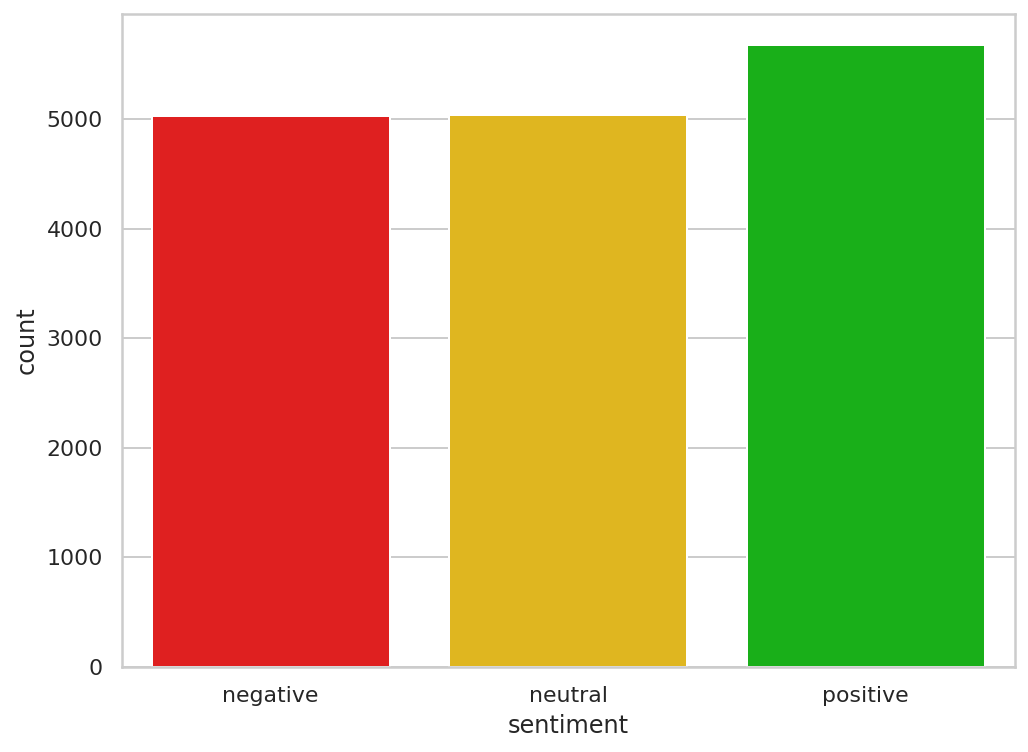

In [ ]:
sns.set_palette(sns.color_palette(["#ff0000", "#ffc800", "#00c800"]))
sns.countplot(df.sentiment).set_xticklabels(tags)
plt.xlabel('sentiment')

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased' 

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
sent = 'My test sentence for tokenization'
tokens = tokenizer.tokenize(sent)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(tokens)
print(token_ids)

['My', 'test', 'sentence', 'for', 'token', '##ization']
[1422, 2774, 5650, 1111, 22559, 2734]


In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
print(tokenizer.max_model_input_sizes[BERT_MODEL_NAME])

512


In [ ]:
encoder = tokenizer.encode_plus(
  sent, add_special_tokens=True,
  max_length=100,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoder['input_ids'].flatten()

tensor([  101,  1422,  2774,  5650,  1111, 22559,  2734,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
encoder['attention_mask'].flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [ ]:
token_lengths = []
for sent in df.content:
  tokens = tokenizer.encode(sent, max_length=tokenizer.max_model_input_sizes[BERT_MODEL_NAME])
  token_lengths.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

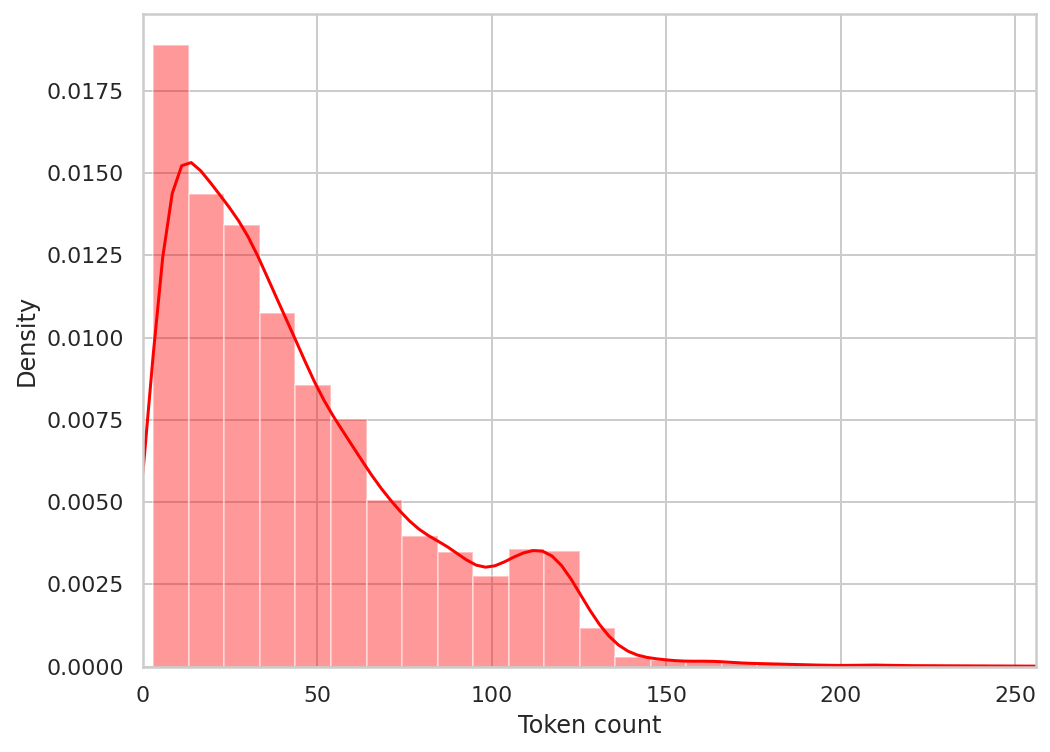

In [ ]:
sns.distplot(token_lengths)
plt.xlim([0, tokenizer.max_model_input_sizes[BERT_MODEL_NAME] // 2])
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 175

In [ ]:
class ReviewsDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, MAX_LEN):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.MAX_LEN = MAX_LEN
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoder = tokenizer.encode_plus(
      review, add_special_tokens=True,
      max_length=self.MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {'review': review, 'input_ids': encoder['input_ids'].flatten(), 'attention_mask': encoder['attention_mask'].flatten(), 'target': torch.tensor(target, dtype=torch.long)}

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
print(df_train.shape, df_val.shape, df_test.shape)

(14171, 12) (787, 12) (788, 12)


In [ ]:
def get_loader(df, tokenizer, MAX_LEN, BATCH_SIZE):
  data = ReviewsDataset(reviews=df.content.to_numpy(), targets=df.sentiment.to_numpy(), tokenizer=tokenizer, MAX_LEN=MAX_LEN)
  loader = DataLoader(data, batch_size=BATCH_SIZE)
  return loader

In [ ]:
BATCH_SIZE = 16

train_loader = get_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = get_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = get_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review', 'input_ids', 'attention_mask', 'target'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)

torch.Size([16, 175])
torch.Size([16, 175])
torch.Size([16])


In [ ]:
bert = BertModel.from_pretrained(BERT_MODEL_NAME)

In [ ]:
res = bert(input_ids = encoder['input_ids'], attention_mask=encoder['attention_mask'])

In [ ]:
res[0].shape

torch.Size([1, 100, 768])

In [ ]:
res[1].shape

torch.Size([1, 768])

In [ ]:
class Analyzer(nn.Module):
  def __init__(self, bert, p, num_tags):
    super(Analyzer, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2out = nn.Linear(self.inp2emb.config.hidden_size, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)[1]
    emb = self.drop(emb)
    out = self.emb2out(emb)
    return out

In [ ]:
class AnalyzerV4(nn.Module):
  def __init__(self, bert, p, num_tags, hid_dim, num_lay):
    super(AnalyzerV4, self).__init__()
    self.inp2emb = bert
    self.drop = nn.Dropout(p=p)
    self.emb2hid0 = nn.Linear(self.inp2emb.config.hidden_size, hid_dim * 2)
    self.emb2hid = nn.GRU(self.inp2emb.config.hidden_size, hid_dim, num_layers=num_lay, bidirectional=True, batch_first=True, dropout=p)
    self.hid2out = nn.Linear(hid_dim * 2, num_tags)

  def forward(self, input_ids, attention_mask):
    emb = self.inp2emb(input_ids=input_ids, attention_mask=attention_mask)
    hid0 = self.emb2hid0(emb[1])
    hid0 = torch.cat((hid0, hid0), dim=1).reshape(4, hid0.size(0), hid0.size(1) // 2)
    h, hid = self.emb2hid(emb[0], hid0)
    hid = self.drop(torch.cat((hid[-2,:,:], hid[-1,:,:]), dim=1))
    out = self.hid2out(hid)
    return out

In [ ]:
analyzer = Analyzer(bert, 0.2, len(tags))
analyzer = analyzer.to(device)

In [ ]:
analyzerV4 = AnalyzerV4(bert, 0.2, len(tags), 256, 2)
analyzerV4 = analyzerV4.to(device)

In [ ]:
analyzer(input_ids = data['input_ids'].to(device), attention_mask=data['attention_mask'].to(device))

tensor([[-0.6077,  0.1259,  0.0871],
        [-0.2972, -0.0164, -0.6364],
        [-0.3720,  0.0907, -1.1108],
        [-0.4113, -0.0718, -0.7567],
        [ 0.0975, -0.4506, -0.5682],
        [-0.4986, -0.2895, -0.8209],
        [-0.0423, -0.4506, -0.2731],
        [-0.3979, -0.5706, -0.9591],
        [ 0.3842, -0.2365, -0.4402],
        [-0.5273, -0.8900, -0.7659],
        [-0.4371, -0.2718, -0.3837],
        [-0.2559, -0.2265, -0.2451],
        [-0.3912, -0.2598, -0.5065],
        [-0.0700, -0.7647, -1.1184],
        [-0.1843, -0.0371, -0.4430],
        [-0.4675, -0.1890, -0.1656]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
nn.Softmax(dim=1)(analyzer(input_ids = data['input_ids'].to(device), attention_mask=data['attention_mask'].to(device)))

tensor([[0.3054, 0.4582, 0.2364],
        [0.4209, 0.3797, 0.1994],
        [0.2750, 0.4481, 0.2769],
        [0.4272, 0.2445, 0.3283],
        [0.3253, 0.4539, 0.2208],
        [0.2833, 0.4156, 0.3011],
        [0.3994, 0.4167, 0.1840],
        [0.4938, 0.3050, 0.2012],
        [0.2782, 0.4554, 0.2664],
        [0.3665, 0.3772, 0.2563],
        [0.3369, 0.3708, 0.2923],
        [0.3563, 0.4401, 0.2036],
        [0.3296, 0.3931, 0.2772],
        [0.3703, 0.3336, 0.2961],
        [0.3553, 0.2966, 0.3480],
        [0.2580, 0.4389, 0.3030]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
nn.Softmax(dim=1)(analyzerV3(input_ids = data['input_ids'].to(device), attention_mask=data['attention_mask'].to(device)))

tensor([[0.2717, 0.3764, 0.3519],
        [0.3384, 0.3279, 0.3337],
        [0.3052, 0.3679, 0.3269],
        [0.3142, 0.3469, 0.3389],
        [0.2551, 0.4141, 0.3308],
        [0.2869, 0.3771, 0.3361],
        [0.3081, 0.3607, 0.3311],
        [0.2773, 0.4380, 0.2847],
        [0.3063, 0.3440, 0.3497],
        [0.3332, 0.2901, 0.3767],
        [0.2949, 0.3760, 0.3292],
        [0.3375, 0.3516, 0.3109],
        [0.2823, 0.4013, 0.3163],
        [0.3137, 0.3250, 0.3613],
        [0.2758, 0.3637, 0.3605],
        [0.3420, 0.3171, 0.3409]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 10
optim = AdamW(analyzer.parameters(), lr=3e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
EPOCHS = 10
optim = AdamW(analyzerV4.parameters(), lr=3e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)
crit = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, loader, crit, optim, device, scheduler, num_ex):
  model = model.train()
  losses = []
  correct = 0

  for data in loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    trg = data['target'].to(device)

    out = model(input_ids=input_ids, attention_mask=attention_mask)
    _, pred = torch.max(out, dim=1)
    loss = crit(out, trg)
    correct += torch.sum(pred == trg)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optim.step()
    scheduler.step()
    optim.zero_grad()
  
  return correct.double() / num_ex, np.mean(losses)

In [ ]:
def eval(model, loader, crit, device, num_ex):
  model = model.eval()
  losses = []
  correct = 0

  with torch.no_grad():
    for data in loader:
      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      trg = data['target'].to(device)

      out = model(input_ids=input_ids, attention_mask=attention_mask)
      _, pred = torch.max(out, dim=1)
      loss = crit(out, trg)
      correct += torch.sum(pred == trg)
      losses.append(loss.item())
  
  return correct.double() / num_ex, np.mean(losses)

In [ ]:
name = 'Agg_02_3e5'
history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(analyzer, train_loader, crit, optim, device, scheduler, len(df_train))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(analyzer, val_loader, crit, device, len(df_val))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(analyzer.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.801925340940667  | Train acc =  tensor(0.6287, device='cuda:0', dtype=torch.float64)
Val loss =  0.691679692864418  | Val acc =  tensor(0.6823, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  0.533202833569615  | Train acc =  tensor(0.7868, device='cuda:0', dtype=torch.float64)
Val loss =  0.6273228268325329  | Val acc =  tensor(0.7751, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  0.3099837662624805  | Train acc =  tensor(0.8937, device='cuda:0', dtype=torch.float64)
Val loss =  0.6663557285815478  | Val acc =  tensor(0.8145, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.20227225720025724  | Train acc =  tensor(0.9388, device='cuda:0', dtype=torch.float64)
Val loss =  0.7856327768601478  | Val acc =  tensor(0.8247, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.1374847204169536  | Train acc =  tensor(0.9618, device='cuda:0', dtype=torch.float64)


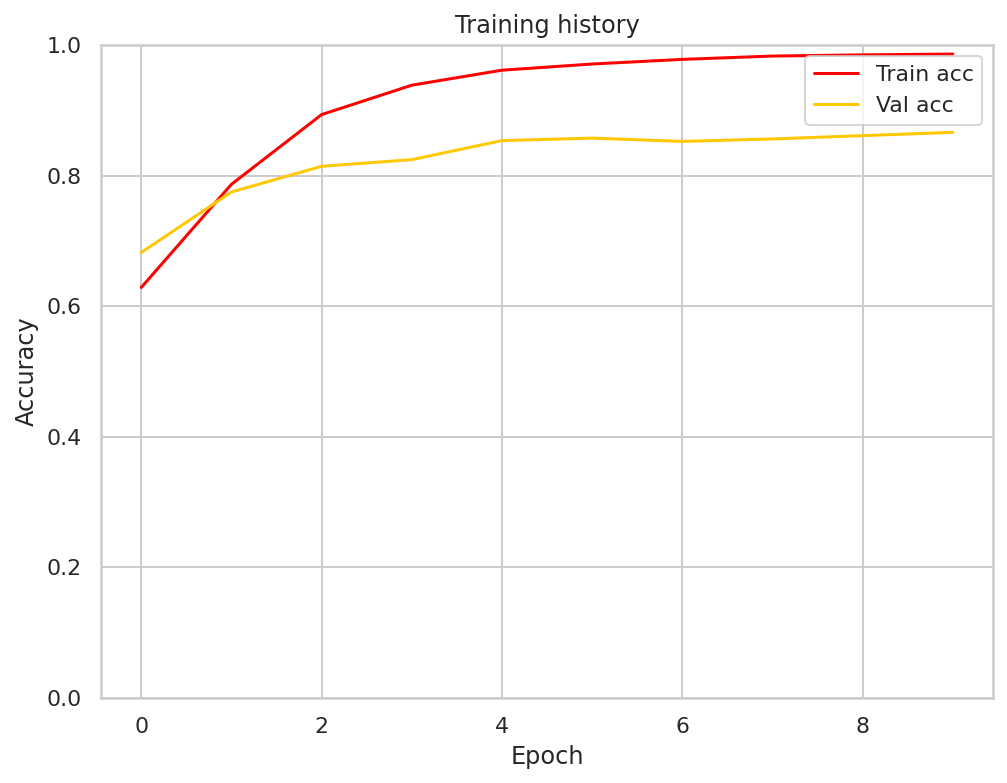

In [ ]:
plt.plot(history['train_acc'], label='Train acc')
plt.plot(history['val_acc'], label='Val acc')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval(analyzer, test_loader, crit, device, len(df_test))
print(test_acc.item())

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.8718274111675126


In [ ]:
def get_info(model, loader):
  model = model.eval()

  preds = []
  trgs = []

  with torch.no_grad():
    for data in loader:

      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      trg = data["target"].to(device)

      out = model(input_ids=input_ids, attention_mask=attention_mask)
      _, pred = torch.max(out, dim=1)

      preds.extend(pred)
      trgs.extend(trg)

  preds = torch.stack(preds).cpu()
  trgs = torch.stack(trgs).cpu()
  return trgs, preds

In [ ]:
def show_info(model, loader):
  trgs, preds = get_info(model, loader)
  print(classification_report(trgs, preds, target_names=tags))
  
  cm = confusion_matrix(trgs, preds)
  df_cm = pd.DataFrame(cm, index=tags, columns=tags)

  hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       262
     neutral       0.83      0.86      0.85       270
    positive       0.90      0.89      0.89       256

    accuracy                           0.87       788
   macro avg       0.87      0.87      0.87       788
weighted avg       0.87      0.87      0.87       788



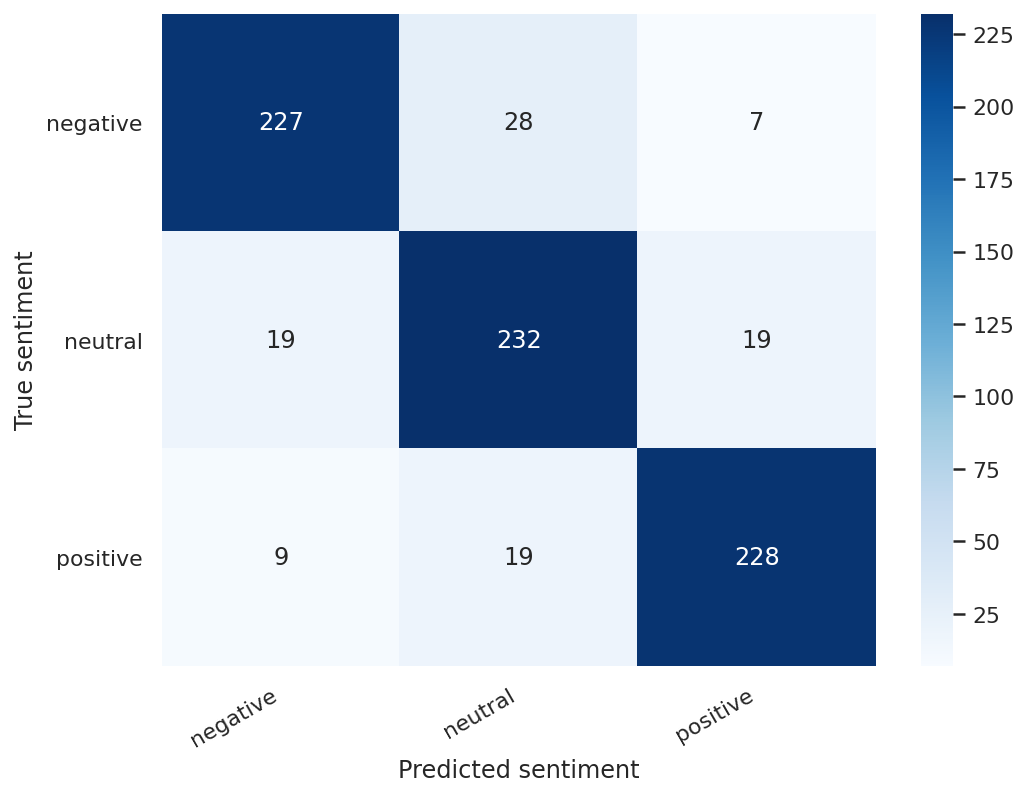

In [ ]:
show_info(analyzer, test_loader)

In [ ]:
analyzer.load_state_dict(torch.load(model_path + 'Agg_02_3e5.pt'))

<All keys matched successfully>

In [ ]:
def analyze(sent):
  encoded = tokenizer.encode_plus(sent, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
  input_ids = encoded['input_ids'].to(device)
  attention_mask = encoded['attention_mask'].to(device)

  out = analyzer(input_ids, attention_mask)
  _, pred = torch.max(out, dim=1)

  return tags[pred]

In [ ]:
analyze("I'm constantly being killed by cheaters! The worst game I've ever seen!")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'negative'

In [ ]:
analyze("Well, it was quite funny but nothing special")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'neutral'

In [ ]:
analyze("What I love about this game is an incredible story of the main character")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'positive'

In [ ]:
analyze("This game is a joke! I've just thrown my money away")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'negative'

In [ ]:
analyze("I was laughing all day long! Cheaters are absolutely everywhere!")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'negative'

In [ ]:
analyze("I was laughing all day long!")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


'positive'

In [ ]:
name = 'SA_V4'
history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
  print('Epoch ', epoch + 1, '/', EPOCHS)
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(analyzerV4, train_loader, crit, optim, device, scheduler, len(df_train))
  print('Train loss = ', train_loss, ' | Train acc = ', train_acc)
  
  val_acc, val_loss = eval(analyzerV4, val_loader, crit, device, len(df_val))
  print('Val loss = ', val_loss, ' | Val acc = ', val_acc)

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(analyzerV4.state_dict(), model_path + name + '.pt')

Epoch  1 / 10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss =  0.7369376627169129  | Train acc =  tensor(0.6700, device='cuda:0', dtype=torch.float64)
Val loss =  0.6295290970802307  | Val acc =  tensor(0.7281, device='cuda:0', dtype=torch.float64)
Epoch  2 / 10
----------
Train loss =  0.4080861080017437  | Train acc =  tensor(0.8454, device='cuda:0', dtype=torch.float64)
Val loss =  0.5465315097570419  | Val acc =  tensor(0.8056, device='cuda:0', dtype=torch.float64)
Epoch  3 / 10
----------
Train loss =  0.20464694183361853  | Train acc =  tensor(0.9335, device='cuda:0', dtype=torch.float64)
Val loss =  0.6813714875280857  | Val acc =  tensor(0.8208, device='cuda:0', dtype=torch.float64)
Epoch  4 / 10
----------
Train loss =  0.12208635443122531  | Train acc =  tensor(0.9610, device='cuda:0', dtype=torch.float64)
Val loss =  0.6937009998969734  | Val acc =  tensor(0.8602, device='cuda:0', dtype=torch.float64)
Epoch  5 / 10
----------
Train loss =  0.0798992199558698  | Train acc =  tensor(0.9756, device='cuda:0', dtype=torch.float